# Задача классификации. Логические модели машинного обучения.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from bayes_opt import BayesianOptimization
from sklearn import preprocessing, pipeline, impute, compose

import warnings
warnings.filterwarnings('ignore')

# Оглавление

1. [Вступление](#introduction)
2. [Общий осмотр данных](#inspection)
3. [Подготовка данных для модели](#prepare_data)
4. [Начальные модели](#baselines)
5. [Результаты начальных моделей в соревновании на Kaggle](#baselines_kaggle)
6. [Оптимизация параметров моделей](#tuning)
7. [Результаты оптимизированных моделей в соревновании на Kaggle](#tuning_kaggle)
8. [Итоги](#resume)

# 1 Вступление <a name = "introduction"></a>

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла.<br>
*Ссылка на соревнование на kaggle с полной постановкой задачи: https://www.kaggle.com/c/telecom-clients-prediction2/overview*

# 2 Общий осмотр данных <a name = "inspection"></a>

Общие пояснения к данным:

* Метки классов: здесь `1` соответствует классу `отток`, `-1` - классу `не отток`
* Данные предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными


In [3]:
df_train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)
df_test = pd.read_csv('orange_small_churn_test_data.csv', index_col = 0)

In [4]:
df_train.head(3)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0


In [5]:
df_train.drop(18298, axis = 0, inplace = True) # это была пустая строка

In [6]:
df_train.labels.isnull().sum()

0

In [7]:
df_test.head(3)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN


In [8]:
df_train.shape, df_test.shape

((18298, 231), (10000, 230))

In [9]:
num_features = list(df_train.columns[:190])
cat_features = list(df_train.columns[190:-1])

y_train = df_train['labels']
print('Процент людей оттока от общего числа пользователей:', 
      round(y_train.value_counts(normalize = True)[1]*100, 3), '%')
print('Процент остающихся людей с компанией от общего числа пользователей:', 
      round(y_train.value_counts(normalize = True)[-1]*100, 3), '%')

Процент людей оттока от общего числа пользователей: 7.525 %
Процент остающихся людей с компанией от общего числа пользователей: 92.475 %


Как видно классы распределены крайне неравномерно, в связи с чем необходимо более качественно подобрать метрики для определения 
качества моделей для данной задачи.

In [10]:
y_train[13000:].value_counts()

-1.0    4904
 1.0     394
Name: labels, dtype: int64

In [11]:
df = pd.concat([df_train.drop('labels', axis = 1), df_test], axis = 0)
df

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,714.0,7.0,NaN,NaN,NaN,...,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN
9996,NaN,NaN,NaN,NaN,NaN,812.0,7.0,NaN,NaN,NaN,...,oslk,sXbT3Cb,LM8l689qOp,NaN,ELof,WqMG,RAYp,55YFVY9,mj86,NaN
9997,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,...,oslk,05jAV0N,M_8D,NaN,ELof,TNEC,RAYp,55YFVY9,am7c,NaN


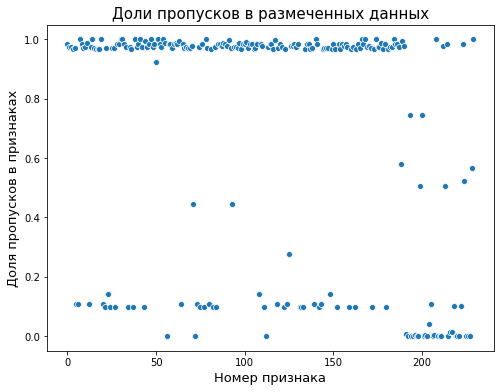

In [12]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = range(df.shape[1]), y = df.isnull().sum()/df.shape[0])
plt.ylabel('Доля пропусков в признаках', {'fontsize': 13})
plt.xlabel('Номер признака', {'fontsize': 13})
plt.title("Доли пропусков в размеченных данных", {'fontsize': 15})
plt.show()

Нетрудно заметить, что очень много атрибутов имеют больше пропусков нежели заполненных данных, некоторые даже не имеют вообще каких-либо значений, кроме пропусков.

# 3 Подготовка данных для моделей <a name = "prepare_data"></a>

Цель этого небольшого проекта - показать применение логических моделей машинного обучения для решения задач классификации с несбалансированным целевым признаком. Поэтому значительную часть разведочного анализа мы пропустим. Но все-таки обратим внимание на некоторые моменты, касающиеся корреляционного анализа признаков и их отбора.

Пропуски в категориальных данных заполняем новыми значениями, в вещественных же средним значением.<br>
Затем все вещественные приводим к одному масштабы, а категориальные признаки кодируем с помощью one-hot-encoding.

Если ориетироваться при отборе призначков на значения корреляций переменных с целевым признаком, то
* Для вещественных признаков используется в качестве значения корреляции "отмасшабированная" разность мат. ожиданий переменных, принадлежащих разным классам.
* Для категориальных переменных используется значение коэффициента корреляции -V Крамера.

Однако, так как коэффициент Крамера основан на значении статистики хи-квадрат, то ограничения, связанные с использованием этой статистики, будут распространяться и на коэффициент Крамера. Бездумно ко всем признакам его применить не получиться. 

Ограничения на применение коэффициент Крамера к признакам:
1. Объем выборки должен быть больше 40
2. В случае анализа многопольных таблиц ожидаемое число наблюдений не должно принимать значения менее 5 более чем в 20% ячеек..

Первое условие всегда выполняется в связи с немалым размером исходных данных. А вот второе уже придется рассматривать в каждой таблице сопряженности. К тому же не стоит забывать про признаки, где только одно значение или вообще нет значений кроме пропусков, а также стоит помнить про призаки, где, наоборот, очень много разных значений.

In [21]:
list_one_value = []

for x in df.select_dtypes(include='O').columns:
    if df[x].nunique() == 1:
        list_one_value.append(x)
        
df[list_one_value].describe()

,Var191,Var213,Var215,Var224
count,589,627,389,467
unique,1,1,1,1
top,r__I,KdSa,eGzu,4n2X
freq,589,627,389,467


In [33]:
# для проверки второго ограничения
for x in df.select_dtypes(include='O').columns:           
    pair_df = pd.concat([df[x][:18298].fillna('Not known'), y_train], axis = 1)
    expect_table = stats.chi2_contingency(pd.crosstab(pair_df[x], pair_df['labels']))[3]
    table = pd.crosstab(pair_df[x], pair_df['labels'])
    
    if table.shape == (2, 2):
        if (expect_table < 5).any():
            print(f"Таблица 2х2, признак {x} не подошел, колво значений признака {df[x].nunique()+1}")
            
    else:
        if (expect_table < 5).sum() > (table.size/5):
            print(f'Многомерная таблица сопряженности, признак {x} не подошел, колво значений признака {df[x].nunique()+1}')

Многомерная таблица сопряженности, признак Var192 не подошел, колво значений признака 341
Многомерная таблица сопряженности, признак Var193 не подошел, колво значений признака 47
Многомерная таблица сопряженности, признак Var194 не подошел, колво значений признака 4
Многомерная таблица сопряженности, признак Var195 не подошел, колво значений признака 23
Многомерная таблица сопряженности, признак Var196 не подошел, колво значений признака 5
Многомерная таблица сопряженности, признак Var197 не подошел, колво значений признака 214
Многомерная таблица сопряженности, признак Var198 не подошел, колво значений признака 3291
Многомерная таблица сопряженности, признак Var199 не подошел, колво значений признака 3489
Многомерная таблица сопряженности, признак Var200 не подошел, колво значений признака 10419
Многомерная таблица сопряженности, признак Var201 не подошел, колво значений признака 3
Многомерная таблица сопряженности, признак Var202 не подошел, колво значений признака 5196
Многомерная т

In [22]:
# корреляция крамера категориальных признаков
cramer_corr = pd.Series(index = df.select_dtypes(include='O').columns)

for x in df.select_dtypes(include='O').columns:    
    if len(df[x].dropna().unique()) > 1:        
        pair_df = pd.concat([df[x][:18298], y_train], axis = 1)
        stat_chi2, p_val, a, b = stats.chi2_contingency(pd.crosstab(pair_df[x], pair_df['labels']))
        
        if p_val > 0.05:
            cramer_corr[x] = np.sqrt(stat_chi2/(pair_df.shape[0]-1)*1)

            
# корреляция вещественных признаков
num_corr = pd.Series(index = df.select_dtypes(exclude='O').columns)

for x in df.select_dtypes(exclude='O').columns:    
    if (df[x].dropna().nunique() != 1) and (len(df[x].dropna()) != 0):        
        pair_df = pd.concat([df[x][:18298], y_train], axis = 1)
        pair_df[x] = (pair_df[x] - pair_df[x].mean())/pair_df[x].std()
        num_corr[x] = pair_df[pair_df['labels'] == -1][x].mean() - pair_df[pair_df['labels'] == 1][x].mean()
            
num_corr.dropna(inplace = True)

In [14]:
# признаки которые показались более-менее полезными
list_inter = ['Var7', 'Var73', 'Var126', 'Var168', 'Var188', 'Var189', 'Var194', 'Var195',\
              'Var201', 'Var203', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', \
              'Var213', 'Var218', 'Var219', 'Var221', 'Var225', 'Var226', 'Var227', 'Var229']

In [16]:
def prepare_dataset(features, dataset):
    prd_data = dataset[features].copy()
    num_feats = [feat for feat in features if feat in num_features]
    cat_feats = [feat for feat in features if feat in cat_features]
    return prd_data, num_feats, cat_feats

In [17]:
df_24, numeric_features, categorical_features = prepare_dataset(list_inter, df.iloc[:18298, :])
y = y_train.apply(lambda x: 0 if x == -1 else 1)

# веществ признаки нормализуем, заполняя пропуски средним 
numeric_transformer = pipeline.Pipeline(steps = [
    ('imputer', impute.SimpleImputer(strategy = 'mean')),
    ('scaler', preprocessing.MinMaxScaler())])

# категориальные признаки запоплняем новыми значениями
categorical_transformer = pipeline.Pipeline(steps = [
    ('imputer', impute.SimpleImputer(strategy = 'constant', fill_value = 'n/a')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = compose.ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])  

# 4 Начальные модели <a name = "baselines"></a>

* В качестве метрики будем использовать устойчивый к несбалансированным классам *roc_auc*. Также будем смотреть на метрики *recall* и *presicion*, чтобы выявлять слабые стороны моделей. И для общей картины добавим *общую точность* и *f1-метрику*.

* Проверять модель будем перекрестной проверкой с автоматической балансировкой классов *(StratisfiedKFold)*. Балансировка здесь очень важна. Если не соблюдать пропорции, то после разбиения может оказаться так, что в некоторых "фолдах" вообще будет только один класс.

* В качестве моделей используем *Случайный лес*; *Классификатор, основанный на гребневой регрессии*; *Градиентный бустинг над решающими деревьями*.

Ссылка на стратегию проверки модели:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [18]:
def cv_baselines_model(model):
    estimator = pipeline.Pipeline(steps = [('preprocessor', preprocessor), ('classifier', model)])
    model_results = cross_validate(estimator, df_24.iloc[:18298, :], y, scoring = scoring, cv = cv)
    for metric in list(model_results.keys())[2:]:    
        print(f'{metric[5:]}: {model_results[metric]}')       
    return model_results

def add_res_inTable(table, res_dict, name_model, named = False):
    res = [res_dict[x].mean() for x in list(res_dict.keys())[2:]]
    table[name_model] = res 
    if named: table.index = list(res_dict.keys())[2:]

In [19]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
proba = pd.DataFrame()
res_baselines = pd.DataFrame()

## 4.1 Классификатор, основанный на гребневой регрессии

Ссылка на описание модели:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html?highlight=ridgeclassifier#sklearn.linear_model.RidgeClassifier

In [20]:
rig = RidgeClassifier(class_weight = 'balanced', max_iter = 500, random_state = 42)
add_res_inTable(proba, cv_baselines_model(rig), 'Ridge Regression')

accuracy: [0.46994536 0.46639344 0.49180328 0.4676141  0.48100574]
precision: [0.03569437 0.04255319 0.04535017 0.03911846 0.04484305]
recall: [0.23272727 0.2826087  0.28623188 0.25818182 0.29090909]
f1: [0.06189555 0.07396871 0.07829534 0.06794258 0.07770763]
roc_auc: [0.29608809 0.32594616 0.33178191 0.32278261 0.34164356]
average_precision: [0.04974314 0.05210812 0.05171575 0.0512117  0.05281662]


## 4.2 Случайный лес

Ссылка на описание модели:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier

In [21]:
forest_clf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', 
                                 max_depth = 6, n_jobs = -1)
add_res_inTable(proba, cv_baselines_model(forest_clf),'Random Forest')

accuracy: [0.66803279 0.67486339 0.66202186 0.64826455 0.67204154]
precision: [0.14501511 0.13556619 0.13348589 0.13226744 0.13088587]
recall: [0.69818182 0.61594203 0.63405797 0.66181818 0.59636364]
f1: [0.24015009 0.22222222 0.2205419  0.22047244 0.21465969]
roc_auc: [0.71627662 0.69980589 0.70450939 0.71652912 0.68994358]
average_precision: [0.18011087 0.18056942 0.16156938 0.19091781 0.151869  ]


## 4.3 Градиентный бустинг над деревьями

Ссылка на описание модели:https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [23]:
xgb = XGBClassifier(n_estimators = 100, max_depth = 6, scale_pos_weight = 1 / y.mean(),
                            learning_rate = 0.01, n_jobs = -1)
add_res_inTable(proba, cv_baselines_model(xgb), 'Gradient Boosting Trees', True)

accuracy: [0.60191257 0.64180328 0.66557377 0.64334518 0.61519541]
precision: [0.12452351 0.13271824 0.13650307 0.12896254 0.1159322 ]
recall: [0.71272727 0.67753623 0.64492754 0.65090909 0.62181818]
f1: [0.21200649 0.22195846 0.22531646 0.2152736  0.19542857]
roc_auc: [0.71420169 0.72008407 0.71969381 0.72226144 0.68529658]
average_precision: [0.2043929  0.1959373  0.18417061 0.18628596 0.14722794]


## 4.4 Таблица результатов

In [24]:
proba

,Ridge Regression,Random Forest,Gradient Boosting Trees
test_accuracy,0.475352,0.665045,0.633566
test_precision,0.041512,0.135444,0.127728
test_recall,0.270132,0.641273,0.661584
test_f1,0.071962,0.223609,0.213997
test_roc_auc,0.323648,0.705413,0.712308
test_average_precision,0.051519,0.173007,0.183603


Нетрудно заметить, что градиентный бустинг и случайный лес дают приближение намного качественее, чем классификатор с гребневой регрессией(что вполне ожидаемо). Для определения лучшего алгоритма необходимо настраивать параметры. Также видно, что на последнем фолде падает качество у логических моделей(примерно на 0.03)

# 5 Результаты начальных моделей в соревновании <a name = "baselines_kaggle"></a>

In [25]:
def submit_model_preds(model, X_train, X_test, y_train, name_file):
    
    est_model = pipeline.Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    est_model.fit(X_train, y_train)
    model_pred = est_model.predict_proba(X_test)[:, 1]
    
    model_answers = pd.DataFrame(np.arange(10000), columns = ['ID'])
    model_answers = model_answers.join(pd.DataFrame(model_pred, columns = ['result']))
    
    model_answers.to_csv(name_file + '.csv', index = False)
     

In [26]:
df_test, numeric_features, categorical_features = prepare_dataset(list_inter, df.iloc[18298:, :])

submit_model_preds(xgb, df_24, df_test, y, 'xgb_answers')
submit_model_preds(forest_clf, df_24, df_test, y, 'forest_answer')

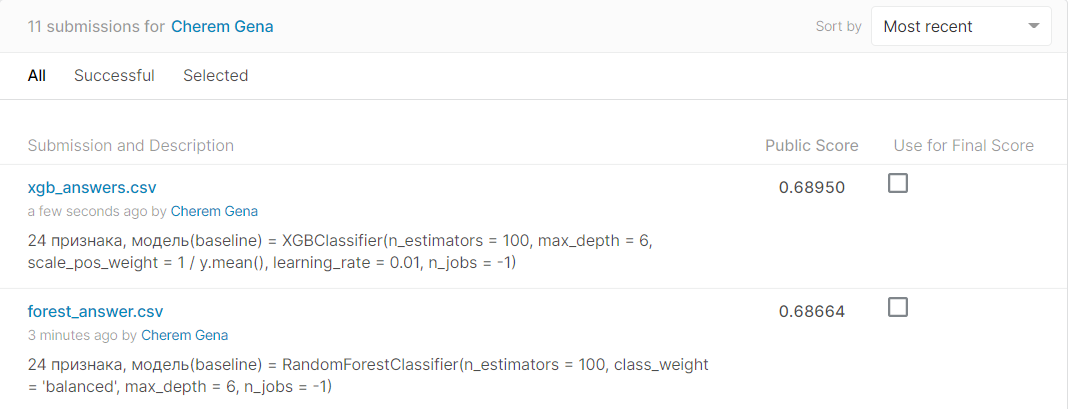

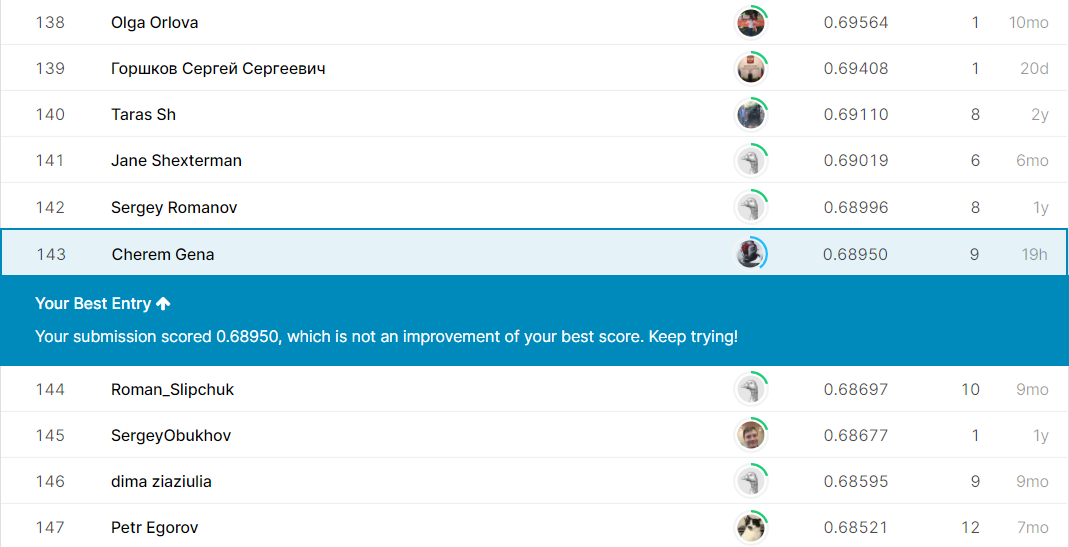

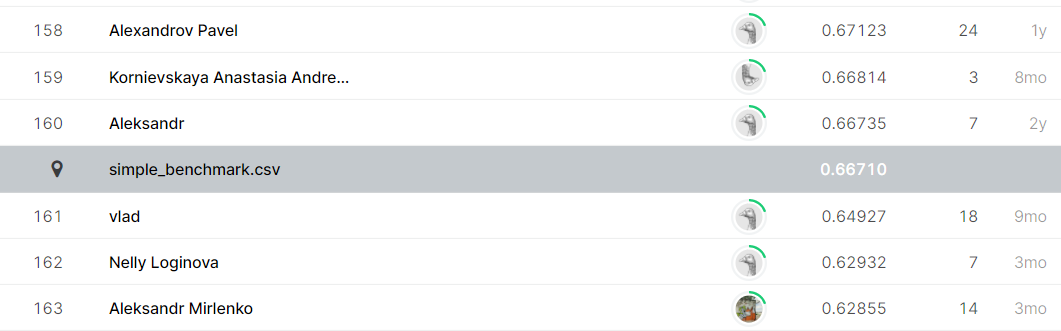

*Выводы:*
* Дефолтный baseline модели успешно преодолели, причем с некоторым отрывом
* Пока модель *случайный лес* немного уступает *градиентному бустингу над деревьями*, но незначительно

# 6 Подбор параметров в моделях <a name = "tuning"></a>

Проводить оптимизацию будем с помощью Гауссовских процессов, в частности Байесовской оптимизации. Она позволит не только быстрее найти параметры, но и подбирать параметры в непрерывном промежутке, а не из множества дискретных значений. Однако "дискретные" параметры подбирать мы не сможем. Подбирать будем исходя из результатов моделей на перекрестной проверке, а также будем "перепроверять" на отложенной выборке, чтобы не получить проблем в виде переобучения и тп.

Ссылка на обьяснение процесса Байесовской оптимизации(там и базовые примеры с применением к моделям): https://github.com/fmfn/BayesianOptimization/blob/master/README.md

In [78]:
X_train = df_24.iloc[:13000, :]
y_train = y[:13000]

X_test = df_24.iloc[13000:18000, :]
y_test = y[13000:18000]

print(f'Доля оттока в выборках:\n  Тестовая = {y_test.mean()} \n  Обучающая = {y_train.mean()} \n  Общая = {y.mean()}')

Доля оттока в выборках:
  Тестовая = 0.08266666666666667 
  Обучающая = 0.07393333333333334 
  Общая = 0.07525412613400372


Доля во всех значительно не отличается, такое разбиение допустимо.

## 6.1 Случайный лес
* Страница со справочной информацией по параметрам:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier
* Объяснение работы модели можно найти здесь:<br>
http://www.machinelearning.ru/wiki/images/0/0d/Voron-ML-Compositions.pdf

In [83]:
# для теста найденных параметров
def test_found_params(res, default_params, method = 'cv'):
    
    bst_params = res['params']
    for key in ['n_estimators', 'max_depth']:
        bst_params[key] = int(bst_params[key])
    bst_params.update(default_params)
    
    print('Best Score on cv-folds = ', res['target'], '\nBest params: ', bst_params)
    print('Pbounds: ', params_for_opt)
    
    cls = pipeline.Pipeline(steps = [('preprocessor', preprocessor), \
                                            ('classifier', RandomForestClassifier(**res['params']))]) 
    
    # тест на отложенной выборке
    if method == 'hold_out':
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        display('Матрица ошибок', confusion_matrix(y_pred, y_test))
        print('Roc_auc = ', roc_auc_score(y_pred, y_test))
        print('Recall = ', recall_score(y_pred, y_test))
        print('Precision = ', precision_score(y_pred, y_test))
    
    # тестирование через перекрестную проверку на 8 фолдах
    if method == 'cv':
        CV = StratifiedKFold(n_splits = 8, random_state = 1)
        cv_resuls = cross_validate(cls, df_24, y, cv = CV, \
                                       scoring = scoring, n_jobs = -1)
        for metric in list(cv_resuls.keys())[2:]:
            print(f'{metric[5:]}: {cv_resuls[metric]}, mean: {cv_resuls[metric].mean()}') 
            
        return {metric[5:]: cv_resuls[metric].mean() for metric in list(cv_resuls.keys())[2:]}
        
        
# функция значений для поиска параметров через Байесовскую оптимизацию  
def random_forest_estimation(n_estimators, max_depth,  max_features):
    params_for_values = {'class_weight': 'balanced',
                        'criterion': 'gini',
                        'n_estimators': int(n_estimators),
                        'max_depth': int(max_depth),
                        'max_features': max_features}
    
    forest_cls = pipeline.Pipeline(steps = [('preprocessor', preprocessor), \
                                            ('classifier', RandomForestClassifier(**params_for_values))]) 
    CV = StratifiedKFold(n_splits = 5, random_state = 1)
    
    forest_cv_resuls = cross_val_score(forest_cls, X_train, y_train, cv = CV, \
                                       scoring = make_scorer(roc_auc_score), n_jobs = -1)
    
    return forest_cv_resuls.mean()


params_for_opt = {'n_estimators': (100, 1000),
                  'max_depth': (5, 13),
                  'max_features': (0.01, 0.35)}

start_params = {'class_weight': 'balanced', 'criterion': 'gini'}

Оптимизировать будем следующие параметры:
* количество деревьев в композиции моделей(n_estimators)
* максимальная глубина деревьев(max_depth)
* количество атрибутов для обучения на подпространствах(max_features)

In [84]:
# поиск оптимальных параметров модели
frs_bo = BayesianOptimization(random_forest_estimation, params_for_opt)
frs_bo.maximize(init_points=20, acq='ei')

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.6287   |  12.99    |  0.2661   |  312.7    |
|  2        |  0.6346   |  11.85    |  0.05412  |  959.6    |
|  3        |  0.642    |  10.63    |  0.2856   |  880.9    |
|  4        |  0.6451   |  10.61    |  0.1916   |  214.3    |
|  5        |  0.6411   |  10.63    |  0.2954   |  561.1    |
|  6        |  0.6456   |  6.561    |  0.07787  |  333.5    |
|  7        |  0.6462   |  7.523    |  0.09459  |  489.2    |
|  8        |  0.629    |  12.13    |  0.2598   |  277.7    |
|  9        |  0.6518   |  5.422    |  0.2973   |  174.7    |
|  10       |  0.6415   |  7.183    |  0.04353  |  912.4    |
|  11       |  0.6413   |  11.97    |  0.2425   |  394.1    |
|  12       |  0.6584   |  7.271    |  0.3176   |  451.7    |
|  13       |  0.6503   |  6.235    |  0.3452   |  962.5    |
|  14       |  0.6382   |  5.67     |  0.03263  |  463.8    |
|  15   

In [90]:
mas_metric = test_found_params(frs_bo.max, start_params)

Best Score on cv-folds =  0.6583968976341962 
Best params:  {'max_depth': 7, 'max_features': 0.31761229439859295, 'n_estimators': 451, 'class_weight': 'balanced', 'criterion': 'gini'}
Pbounds:  {'n_estimators': (100, 1000), 'max_depth': (5, 13), 'max_features': (0.01, 0.35)}
accuracy: [0.66171329 0.6756993  0.69698295 0.68342807 0.68473983 0.6974202
 0.66243988 0.68911237], mean: 0.6814419866316456
precision: [0.13470874 0.14392991 0.14557823 0.13874346 0.14762516 0.14769648
 0.13144963 0.14678899], mean: 0.14206507459333564
recall: [0.64534884 0.66473988 0.62209302 0.61627907 0.66860465 0.63372093
 0.62209302 0.65116279], mean: 0.6405052762468073
f1: [0.22289157 0.23662551 0.23594267 0.22649573 0.24185068 0.23956044
 0.21703854 0.23957219], mean: 0.23249716630242706
roc_auc: [0.71836808 0.72712663 0.72325581 0.71200588 0.7375859  0.73817005
 0.69616526 0.73434218], mean: 0.7233774767227483
average_precision: [0.20271413 0.21876811 0.18585818 0.19078647 0.17280589 0.20602347
 0.1767623

In [91]:
display('Качество на начальной модели', proba['Random Forest'])

'Качество на начальной модели'

test_accuracy             0.665045
test_precision            0.135444
test_recall               0.641273
test_f1                   0.223609
test_roc_auc              0.705413
test_average_precision    0.173007
Name: Random Forest, dtype: float64

In [92]:
bst_params = frs_bo.max['params']
for key in ['n_estimators', 'max_depth']:
    bst_params[key] = int(bst_params[key])
bst_params.update(start_params)

adv_forest = RandomForestClassifier(**bst_params)

In [32]:
display('Качество на оптимизированной модели', mas_metric)

'Качество на оптимизированной модели'

{'accuracy': 0.6255335483547935,
 'precision': 0.12947433861168361,
 'recall': 0.6942423376797957,
 'f1': 0.21821726924297757,
 'roc_auc': 0.719378829929253,
 'average_precision': 0.18949829850581904}

* Увеличились незначительно: roc-auc, avr_precision
* Уменьшились незначительно: f1-score, precision
* Увеличилось значительно: recall
* Уменьшилось значительно: accuracy

## 6.2 Градиентный бустинг деревьев
* Страница со справочной информацией о параметрах модели:<br>
https://xgboost.readthedocs.io/en/latest/parameter.html
* Объяснение работы алгоритма:<br>http://www.machinelearning.ru/wiki/index.php?title=Градиентный_бустинг

In [73]:
def test_found_params_xgb(res, default_params, method = 'cv'):
    bst_params = res['params']
    for key in ['n_estimators', 'max_depth']:
        bst_params[key] = int(bst_params[key])
    bst_params.update(default_params)   
    print('Best Score on cv-folds = ', res['target'], '\nBest params: ', bst_params)
    print('Pbounds: ', params_for_opt_xgb)    
    cls = pipeline.Pipeline(steps = [('preprocessor', preprocessor), \
                                            ('classifier', XGBClassifier(**res['params']))])     
    # тест на отложенной выборке
    if method == 'hold_out':
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        display('Матрица ошибок', confusion_matrix(y_pred, y_test))
        print('Roc_auc = ', roc_auc_score(y_pred, y_test))
        print('Recall = ', recall_score(y_pred, y_test))
        print('Precision = ', precision_score(y_pred, y_test))

    # тестирование через перекрестную проверку на 8 фолдах
    if method == 'cv':
        CV = StratifiedKFold(n_splits = 8, random_state = 1)
        cv_resuls = cross_validate(cls, df_24, y, cv = CV, scoring = scoring, n_jobs = -1)
        for metric in list(cv_resuls.keys())[2:]:
            print(f'{metric[5:]}:{cv_resuls[metric]}') 
            
        return {metric[5:]: cv_resuls[metric].mean() for metric in list(cv_resuls.keys())[2:]}
        
        
# функция значений для поиска параметров через Байесовскую оптимизацию  
def estimation_xgb(n_estimators, max_depth,  max_features, delta, scale):
    params_for_values = {'class_weight': 'balanced',
                        'criterion': 'gini',                        
                         'tree_method': 'hist',
                        'n_estimators': int(n_estimators),
                        'max_depth': int(max_depth),
                        'max_features': max_features,
                         'max_delta_step': delta,
                         'scale_pos_weight': scale}

    xgb_cls = pipeline.Pipeline(steps = [('preprocessor', preprocessor), \
                                            ('classifier', XGBClassifier(**params_for_values))]) 
    CV = StratifiedKFold(n_splits = 5, random_state = 1)    
    xgb_cv_resuls = cross_val_score(xgb_cls, X_train, y_train, cv = CV, \
                                       scoring = make_scorer(roc_auc_score), n_jobs = -1)   
    return xgb_cv_resuls.mean()


params_for_opt_xgb = {'n_estimators': (100, 1000),
                  'max_depth': (5, 15),
                  'max_features': (0.01, 0.35),
                  'delta':(0, 10),
                  'scale': (10, 20)}

start_params_xgb = {'class_weight': 'balanced', 
                    'criterion': 'gini', 
                    'tree_method': 'hist'}

Оптимизировать параметры будем вместе с теми, что были в случайном лесе. А также еще добавим 2 группы параметров для оптимизации:
* 1 группа - параметры, которые используют для устранения проблемы переобучения *(alpha, gamma, eta, lambda)
* 2 группа - параметры, которые используют в случаях несбалансированных долей классов в выборке *(scale_pos_weight, max_delta_step)

In [63]:
# поиск оптимальных параметров модели
xgb_bo = BayesianOptimization(estimation_xgb, params_for_opt_xgb)
xgb_bo.maximize(init_points=20, acq='ei')

|   iter    |  target   |   alpha   |    eta    |    lam    | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.5506   |  0.2707   |  0.6687   |  95.67    |  8.581    |  0.05301  |  441.4    |
|  2        |  0.6159   |  0.9958   |  0.0254   |  12.71    |  12.94    |  0.03766  |  142.6    |
|  3        |  0.5577   |  0.569    |  0.2664   |  8.559    |  7.001    |  0.06126  |  514.5    |
|  4        |  0.599    |  0.3792   |  0.1263   |  52.46    |  7.422    |  0.276    |  330.8    |
|  5        |  0.5515   |  0.06051  |  0.7649   |  6.674    |  5.123    |  0.2268   |  833.8    |
|  6        |  0.5471   |  0.1569   |  0.4965   |  85.15    |  13.38    |  0.1338   |  769.5    |
|  7        |  0.5456   |  0.5977   |  0.6138   |  73.44    |  14.65    |  0.291    |  475.3    |
|  8        |  0.5462   |  0.9149   |  0.6617   |  80.23    |  14.46    |  0.3422   |  651.0    |
|  9        |  0.549

In [99]:
mas_metric = test_found_params_xgb(xgb_bo.max, start_params_xgb)

Best Score on cv-folds =  0.6638233906801743 
Best params:  {'delta': 0.4246550459550724, 'max_depth': 5, 'max_features': 0.22601504623846244, 'n_estimators': 100, 'scale': 11.41275557183365, 'class_weight': 'balanced', 'criterion': 'gini', 'tree_method': 'hist'}
Pbounds:  {'n_estimators': (100, 1000), 'max_depth': (5, 15), 'max_features': (0.01, 0.35), 'delta': (0, 10), 'scale': (10, 20)}
accuracy: mean: 0.9257296867976799
precision: mean: 0.6934523809523809
recall: mean: 0.02324741228659766
f1: mean: 0.044629366735862486
roc_auc: mean: 0.7273845554193281
average_precision: mean: 0.22679730960939087


In [38]:
display('Качество на начальной модели', proba['Gradient Boosting Trees. bg54,mhgfdsa\78+'])

'Качество на начальной модели'

test_accuracy             0.633566
test_precision            0.127728
test_recall               0.661584
test_f1                   0.213997
test_roc_auc              0.712308
test_average_precision    0.183603
Name: Gradient Boosting Trees, dtype: float64

Для некоторых случаев, когда набор данных крайне несбалансирован существует два способа улучшить обучение модели XGBoost:
* Настроить положительный и отрицательный веса с помощью scale_pos_weight
* Использовать AUC для оценки, установить для параметра max_delta_step конечное число, чтобы помочь сходимости модели

Ряд других параметров помогают преодолеть проблему переобучения. В список этих параметров входят: alpha, gamma, eta, lambda, max_depth, min_child_weight, и т.п. <br><i>Наша главная проблема при обучении на полученных данных - несбалансированность целевой выборки, а не переобучение.</i>  Поэтому мы при подборе оптимальных параметров из вышеуказанных и не получаем значимое улучшение результатов, значимое улучшение можно получить при подборе параметров 2группы или при более тщательных преобразовании и подготовке данных.

Запуски байесовской оптимизации параметров 1 группы(по умолчанию включены параметры использованные на случайном лесе).<br>
Их результаты(по метрике roc-auc-score):
* {eta}: немного хуже чем случ. лес(0.71)
* {lambda}: дает примерно тоже, что и случайный лес(0.72)
* {alpha}: примерно тоже что и случайный лес(0.719)
* {lambda, alpha}: примерно тоже как и случ лес(0.719)
* {lambda, alpha, eta}: немного хуже(0.71)

Даже если рассматривать результаты начальной модели, видно, что значимого прироста качества добиться не удалось, что также свидетельствует о проблеме несбалансированности выборки, а не переобучении. Попробуем подобрать параметры, которые в теории могут улучшить качество предсказаний модели. 

In [74]:
# поиск оптимальных параметров модели из 2 группы параметров
xgb_bo = BayesianOptimization(estimation_xgb, params_for_opt_xgb)
xgb_bo.maximize(init_points=20, acq='ei')

|   iter    |  target   |   delta   | max_depth | max_fe... | n_esti... |   scale   |
-------------------------------------------------------------------------------------
|  1        |  0.5537   |  6.544    |  13.55    |  0.1479   |  730.9    |  15.21    |
|  2        |  0.6057   |  9.812    |  6.494    |  0.2127   |  531.1    |  13.04    |
|  3        |  0.6511   |  2.525    |  5.295    |  0.1442   |  178.2    |  19.35    |
|  4        |  0.5756   |  8.564    |  10.74    |  0.1923   |  324.4    |  16.1     |
|  5        |  0.5575   |  3.915    |  10.36    |  0.1417   |  538.2    |  17.09    |
|  6        |  0.6388   |  0.3236   |  5.212    |  0.3447   |  918.9    |  10.76    |
|  7        |  0.619    |  3.804    |  7.074    |  0.2221   |  265.0    |  17.47    |
|  8        |  0.5611   |  4.5      |  12.67    |  0.1466   |  326.9    |  19.03    |
|  9        |  0.5912   |  4.867    |  6.018    |  0.1589   |  865.2    |  19.44    |
|  10       |  0.5523   |  7.436    |  12.9     |  0.2

In [97]:
mas_metric = test_found_params_xgb(xgb_bo.max, start_params_xgb)

Best Score on cv-folds =  0.6638233906801743 
Best params:  {'delta': 0.4246550459550724, 'max_depth': 5, 'max_features': 0.22601504623846244, 'n_estimators': 100, 'scale': 11.41275557183365, 'class_weight': 'balanced', 'criterion': 'gini', 'tree_method': 'hist'}
Pbounds:  {'n_estimators': (100, 1000), 'max_depth': (5, 15), 'max_features': (0.01, 0.35), 'delta': (0, 10), 'scale': (10, 20)}
accuracy: mean: 0.9257296867976799
precision: mean: 0.6934523809523809
recall: mean: 0.02324741228659766
f1: mean: 0.044629366735862486
roc_auc: mean: 0.7273845554193281
average_precision: mean: 0.22679730960939087


Уже заметно, что настройка одного верного параметра дает улучшение больше, чем настройка сразу нескольких параметров, которые не связаны с нашей проблемой в данных, но по целевой метрике качество увеличилось не намного. Однако по другим метрикам, значения стали координально отличаться.

In [80]:
bst_params = xgb_bo.max['params']
for key in ['n_estimators', 'max_depth']:
    bst_params[key] = int(bst_params[key])
bst_params.update(start_params_xgb)

adv_xgb = XGBClassifier(**bst_params)

# 7 Результат в соревнованиях оптимизированных моделей <a name = "tuning_kaggle"></a>

In [94]:
submit_model_preds(adv_xgb, df_24, df_test, y, 'advanced_xgb')
submit_model_preds(adv_forest, df_24, df_test, y, 'advanced_forest')

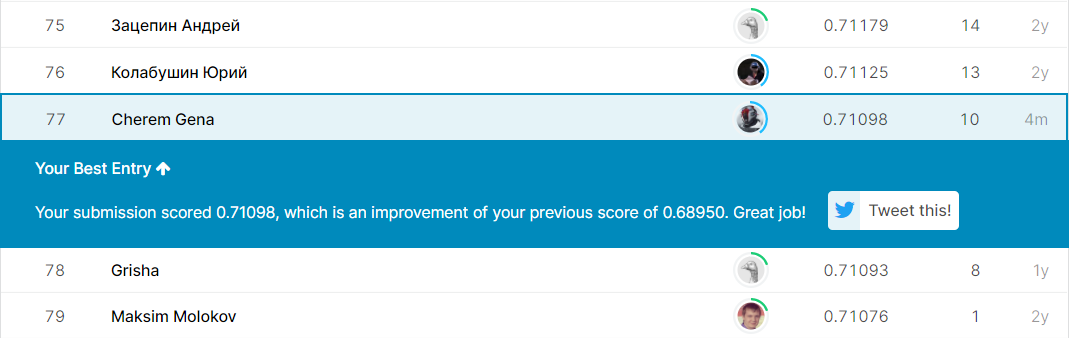

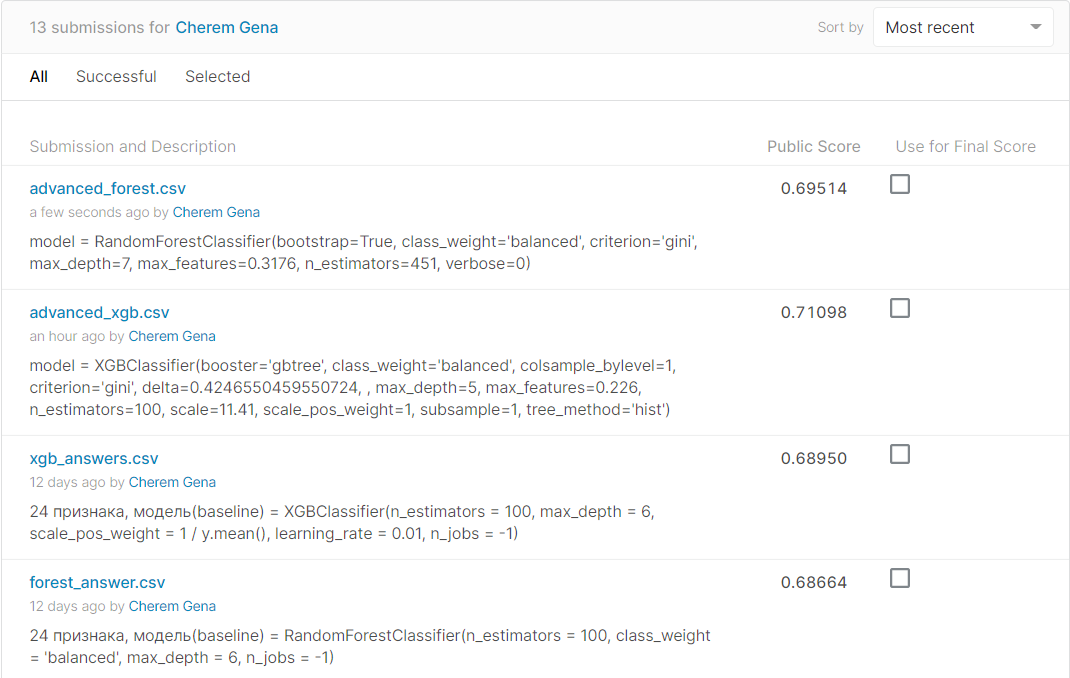

Вот такой результат выдала новая модель градиентного бустинга с подобранными параметрами(на соревновании этот прирост дал прирост на ~ 70 мест)

*Выводы:* 
* Лидер соревнования - модель с качеством ~ 0.73. Если учитывать то, что не было тщательной обработки признаков, как и предподготовки данных, то это вполне неплохой результат. 
* По качеству *модель градиентного бустинга с оптимизацией параметров для регуляризации(alpha, gamma, lambda, eta)* примерно такая же, как и *случайный лес с оптимизацией параметров*
* Лучшая модель - *градиентный бустинг с оптимизацией параметров(для несбалансированный выборок: scale_weight, max_delta_step)*

# 8 Итоги <a name = "resume"></a>

* Логические модели очень часто применяются для задач классификации. Самые известные из которых - *случайный лес и градиантный бустинг над решающими деревьями*. Эти модели имеют множество преимуществ перед другими, однако далеко не лишены недостатков. Имеем прикладную задачу с данными, которые приближены к реальным(разрежены и несбалансированны). Постановка задачи - определить людей из клиентов компании, которые хотят уйти к другим конкурентам(задача классификации) c помощью логических моделей машинного обучения.<br><br>
* Применив разные модели на этих данных, стало ясно, что без дополнительной обработки данных линейные модели имеют качество намного хуже, чем логические модели. Проведя оптимизацию параметров с помощью *Гауссовских процессов(а конктретно Байесовской оптимизации)*, мы увидели, что прирост качества не очень высок. Это связано со специфичностью изначальных данных, при их дополнительной обработке можно поднять качество моделей.<br><br>
* Лучшей моделью, как и предполагалось, оказалась модель градиентного бустинга над решающими деревьями, с оптимизированными параметрами для работы с несбалансированными выборками.